# *Process list of ParOSol outputs*
Voxel-uFE models solved in ParOSol

Created on:  14.11.2025 <br />
Last update: 28.11.2025 <br />

- By: [Gianluca Iori](https://github.com/gianthk), 2025
- Code license: MIT
- Narrative license: CC-BY-NC-SA

---
## Aims
![](./../../fem_pipeline.png)
This notebook does:
1. Load list of ParOSol `.h5` output files
2. Calculate apparent elastic modulus from reaction forces


---
## Configuration and imports

In [1]:
import sys
# sys.path.append('./../../')

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

import h5py

from ciclope.utils.postprocess import reaction_forces

/home/giiori/myterminus/code/micromamba/envs/ciclope/lib/python3.11/site-packages/ciclope/utils/postprocess.py:16: RuntimeWarning: ParaView.simple is required!
  warnings.warn("ParaView.simple is required!", RuntimeWarning)


## Load list of files

In [4]:
# Load BV/TV set

# data_path = '~/terminus/external/tacosound/HR-pQCT_II/parosol/20251105_125728/'
data_path = '~/terminus/external/tacosound/HR-pQCT_II/parosol/20251118_164210/results/'
file_list = 'parosol_models_pure_QCT.lst'
stats_file = '~/myterminus/code/supertab/stat_outputs/parosol_models_pure_QCT.csv'

In [ ]:
# High BV/TV set

# data_path = '~/terminus/external/tacosound/HR-pQCT_II/parosol/20251105_125728/'
data_path = '~/terminus/external/tacosound/HR-pQCT_II/parosol/20251121_144555/results/'
file_list = 'parosol_models_pure_QCT.lst'
stats_file = '~/myterminus/code/supertab/stat_outputs/20251121_144555_parosol_models_pure_QCT.csv'

In [17]:
# Read list of filenames from .lst file
lst_file_path = os.path.join(os.path.expanduser(data_path), file_list)

with open(lst_file_path, 'r') as f:
    file_paths = [line.strip() for line in f.readlines()]

# Replace absolute paths with data_path
file_paths = [os.path.join(os.path.expanduser(data_path), os.path.basename(fpath)) for fpath in file_paths]

print(f"Loaded {len(file_paths)} files from {file_list}")
for i, fpath in enumerate(file_paths):
    print(f"  {i+1}: {fpath}")

Loaded 12 files from parosol_models_pure_QCT.lst
  1: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251121_144555/results/hr_idx0.h5
  2: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251121_144555/results/hr_idx1.h5
  3: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251121_144555/results/hr_idx2.h5
  4: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251121_144555/results/hr_idx3.h5
  5: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251121_144555/results/sr_idx0.h5
  6: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251121_144555/results/sr_idx1.h5
  7: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251121_144555/results/sr_idx2.h5
  8: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251121_144555/results/sr_idx3.h5
  9: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251121_144555/results/lr_idx0.h5
  10: /home/giiori/terminus/external/tacosound/HR-p

## Post-processing of FE results
### Read ParOSol output and Reaction forces

In [18]:
plane_lock_num = 10
slice_level = plane_lock_num + 1

In [19]:
# Read results for all files and store in DataFrame
import re
results_list = []

for fpath in file_paths:
    try:
        res = reaction_forces(fpath, slice_level)
        base = os.path.basename(fpath)
        # scale is prefix before first underscore (e.g., 'hr', 'sr', 'lr')
        scale = base.split('_')[0]
        # extract numeric index after 'idx'
        m = re.search(r'idx(\d+)', base)
        idx = int(m.group(1)) if m else None

        res['file'] = base
        res['idx'] = idx
        res['scale'] = scale
        res['model'] = Path(base).stem
        results_list.append(res)
    except Exception as e:
        print(f"Error processing {fpath}: {e}")

# Create DataFrame from results
df_results = pd.DataFrame(results_list)

# Normalize types: idx as integer (nullable Int64)
if 'idx' in df_results.columns:
    df_results['idx'] = pd.to_numeric(df_results['idx'], errors='coerce').astype('Int64')

df_results = df_results.rename(columns={'idx': 'patch_idx', 'scale': 'source'})
df_results['source'] = df_results['source'].str.upper()
df_results.set_index('model')

print(f"Created DataFrame with {len(df_results)} rows")
df_results.head()

Created DataFrame with 12 rows


,Z_min,Z_max,total_force,F_tot,num_nodes,num_elements,vs,nodes_z0_count,nodes_z1_count,file,patch_idx,source,model
0,7.4538,7.7568,"[-33.73400192780929, 51.799633685987004, -215....",224.669167,4132455,2926108,0.0303,63468,101941,hr_idx0.h5,0,HR,hr_idx0
1,7.4538,7.7568,"[1.909618807721094, 45.57330952397998, -120.66...",129.000466,3802049,2542859,0.0303,83138,29020,hr_idx1.h5,1,HR,hr_idx1
2,7.4538,7.7568,"[-3.781825884192806, 12.180458224032302, -33.4...",35.756720,2462559,1598773,0.0303,67703,22407,hr_idx2.h5,2,HR,hr_idx2
3,7.4538,7.7568,"[-12.373294858774123, 76.75159588984899, -257....",269.308187,4817231,3359954,0.0303,79684,96712,hr_idx3.h5,3,HR,hr_idx3
4,7.4538,7.7568,"[-14.085983059275705, 21.532902130429406, -131...",133.916967,5935863,3931367,0.0303,88110,137391,sr_idx0.h5,0,SR,sr_idx0


In [20]:
# Read stats file
stats_path = os.path.expanduser(stats_file)
df_stats = pd.read_csv(stats_path)
df_stats = df_stats.rename(columns={'bone_volume_fraction': 'BVTV'})
df_stats['model'] = None
for i, row in df_stats.iterrows():
    df_stats.at[i, 'model'] = os.path.splitext(os.path.basename(row['model_name']))[0]
# df_stats['model'] = os.path.splitext(os.path.basename(df_stats['model_name']))[0]

df_stats.set_index('model')

print(f"Loaded stats from {stats_file}")
print(f"Shape: {df_stats.shape}")
df_stats.head()

Loaded stats from ~/myterminus/code/supertab/stat_outputs/parosol_models_pure_QCT.csv
Shape: (12, 6)


,model_name,BVTV,position,patch_idx,source,model
0,/usr/terminus/data-xrm-01/stamplab/external/ta...,0.176298,"([4096, 4352], [1536, 1792], [2304, 2560])",0,HR,hr_idx0
1,/usr/terminus/data-xrm-01/stamplab/external/ta...,0.152238,"([4352, 4608], [1024, 1280], [2048, 2304])",1,HR,hr_idx1
2,/usr/terminus/data-xrm-01/stamplab/external/ta...,0.099210,"([4352, 4608], [1024, 1280], [2304, 2560])",2,HR,hr_idx2
3,/usr/terminus/data-xrm-01/stamplab/external/ta...,0.200799,"([4352, 4608], [1280, 1536], [2048, 2304])",3,HR,hr_idx3
4,/usr/terminus/data-xrm-01/stamplab/external/ta...,0.307392,"([4096, 4352], [1536, 1792], [2304, 2560])",0,LR,lr_idx0


In [21]:
df_results = pd.merge(df_results, df_stats)

In [23]:
df_results.shape

(12, 16)

In [22]:
df_results.head()

,Z_min,Z_max,total_force,F_tot,num_nodes,num_elements,vs,nodes_z0_count,nodes_z1_count,file,patch_idx,source,model,model_name,BVTV,position
0,7.4538,7.7568,"[-33.73400192780929, 51.799633685987004, -215....",224.669167,4132455,2926108,0.0303,63468,101941,hr_idx0.h5,0,HR,hr_idx0,/usr/terminus/data-xrm-01/stamplab/external/ta...,0.176298,"([4096, 4352], [1536, 1792], [2304, 2560])"
1,7.4538,7.7568,"[1.909618807721094, 45.57330952397998, -120.66...",129.000466,3802049,2542859,0.0303,83138,29020,hr_idx1.h5,1,HR,hr_idx1,/usr/terminus/data-xrm-01/stamplab/external/ta...,0.152238,"([4352, 4608], [1024, 1280], [2048, 2304])"
2,7.4538,7.7568,"[-3.781825884192806, 12.180458224032302, -33.4...",35.756720,2462559,1598773,0.0303,67703,22407,hr_idx2.h5,2,HR,hr_idx2,/usr/terminus/data-xrm-01/stamplab/external/ta...,0.099210,"([4352, 4608], [1024, 1280], [2304, 2560])"
3,7.4538,7.7568,"[-12.373294858774123, 76.75159588984899, -257....",269.308187,4817231,3359954,0.0303,79684,96712,hr_idx3.h5,3,HR,hr_idx3,/usr/terminus/data-xrm-01/stamplab/external/ta...,0.200799,"([4352, 4608], [1280, 1536], [2048, 2304])"
4,7.4538,7.7568,"[-14.085983059275705, 21.532902130429406, -131...",133.916967,5935863,3931367,0.0303,88110,137391,sr_idx0.h5,0,SR,sr_idx0,/usr/terminus/data-xrm-01/stamplab/external/ta...,0.236764,"([4096, 4352], [1536, 1792], [2304, 2560])"


/tmp/ipykernel_2317947/2370367567.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left')


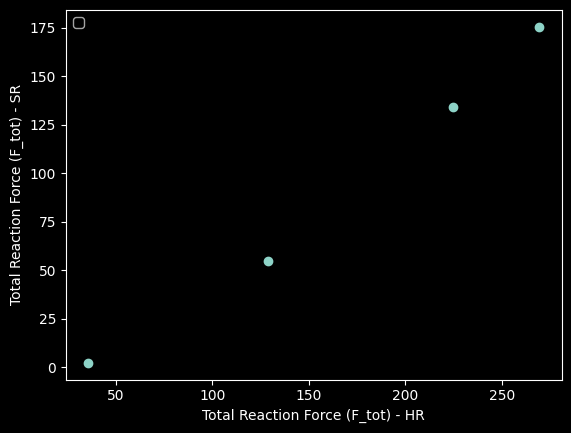

In [24]:
plt.scatter(df_results[df_results['source'] == 'HR']['F_tot'], df_results[df_results['source'] == 'SR']['F_tot'])
plt.xlabel('Total Reaction Force (F_tot) - HR')
plt.ylabel('Total Reaction Force (F_tot) - SR')
plt.legend(loc='upper left')
# plt.title('F_tot vs Bone Volume Fraction for SR models')

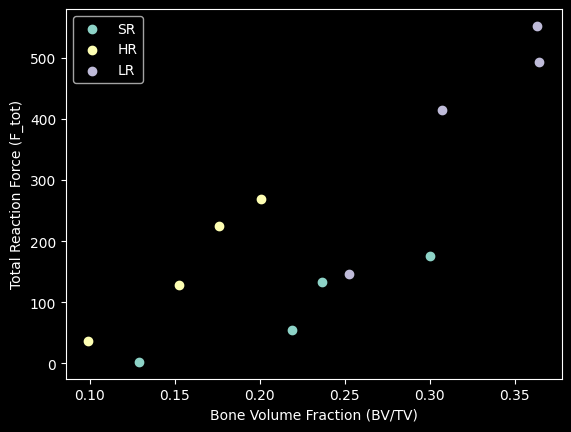

In [25]:
plt.scatter(df_results[df_results['source'] == 'SR']['BVTV'], df_results[df_results['source'] == 'SR']['F_tot'], label='SR')
plt.scatter(df_results[df_results['source'] == 'HR']['BVTV'], df_results[df_results['source'] == 'HR']['F_tot'], label='HR')
plt.scatter(df_results[df_results['source'] == 'LR']['BVTV'], df_results[df_results['source'] == 'LR']['F_tot'], label='LR')
plt.xlabel('Bone Volume Fraction (BV/TV)')
plt.ylabel('Total Reaction Force (F_tot)')
plt.legend(loc='upper left')
# plt.title('F_tot vs Bone Volume Fraction for SR models')

In [13]:
df_results[df_results['source']=='LR']

,Z_min,Z_max,total_force,F_tot,num_nodes,num_elements,vs,nodes_z0_count,nodes_z1_count,file,patch_idx,source,model,model_name,BVTV,position
8,7.4538,7.7568,"[3.595375407495213, 15.690436424318207, -117.0...",118.155284,2860322,2454539,0.0303,44815,48510,lr_idx0.h5,0,LR,lr_idx0,/usr/terminus/data-xrm-01/stamplab/external/ta...,0.307392,"([4096, 4352], [1536, 1792], [2304, 2560])"
9,7.4538,7.7568,"[28.79201224742925, -1.659092470913416, -153.8...",156.496410,2703516,2312900,0.0303,55520,38815,lr_idx1.h5,1,LR,lr_idx1,/usr/terminus/data-xrm-01/stamplab/external/ta...,0.364333,"([4352, 4608], [1024, 1280], [2048, 2304])"
10,7.4538,7.7568,"[2.6398162195871655, 14.949115852125509, -86.5...",87.898480,3325044,2814843,0.0303,57720,55035,lr_idx2.h5,2,LR,lr_idx2,/usr/terminus/data-xrm-01/stamplab/external/ta...,0.252507,"([4352, 4608], [1024, 1280], [2304, 2560])"
11,7.4538,7.7568,"[9.818505723045929, 22.136829130663912, -95.17...",98.210191,4307071,3655654,0.0303,56390,79065,lr_idx3.h5,3,LR,lr_idx3,/usr/terminus/data-xrm-01/stamplab/external/ta...,0.362731,"([4352, 4608], [1280, 1536], [2048, 2304])"


### Apparent elastic modulus
`E_app = (F_tot / A) / epsilon`

In [13]:
voxel_size_mm=0.0303
cube_size = 256
topDisplacement=-0.004 * cube_size * voxel_size_mm

A = (cube_size*voxel_size_mm)**2 # [mm2]
epsilon = np.abs(topDisplacement)/(cube_size*voxel_size_mm)

In [14]:
print(topDisplacement)

-0.0310272


In [17]:
print((df_results[df_results['scale'] == 'hr']['F_tot']/A)/epsilon)

0     3.809135
1    80.394552
2     2.749475
3     1.919317
4    66.644028
Name: F_tot, dtype: float64
